# DTM  Classifier

In [1]:
import pandas as pd
from Data_preparation_Library import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from time import time
from sklearn.model_selection import train_test_split
from keras.models import load_model
from random import choice
from pickle import load

## Data Analysis Section

<AxesSubplot:title={'center':'Subjects/Fazil/day_04_24_21/computed_Hammer02.csv'}>

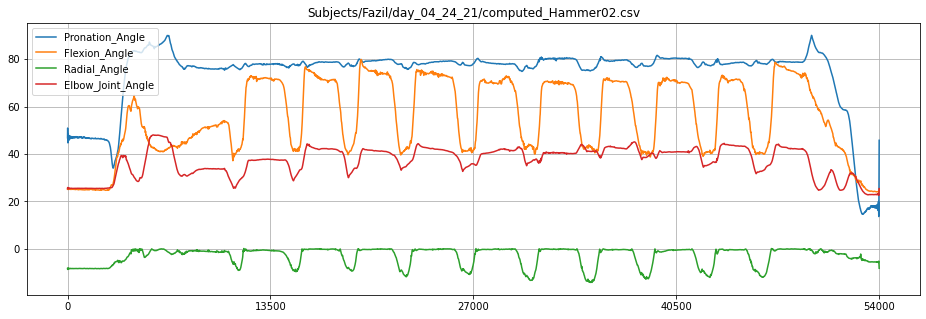

In [2]:
file = 'Subjects/Fazil/day_04_24_21/computed_Hammer02.csv'
angle_lables = ['Pronation_Angle','Flexion_Angle',  'Radial_Angle','Elbow_Joint_Angle']
df = pd.read_csv(file,index_col=0)
df[angle_lables].plot(figsize=(16,5),title=file,grid=True,xticks=np.linspace(0,len(df),5))

In [3]:
df = df[13500:27000]

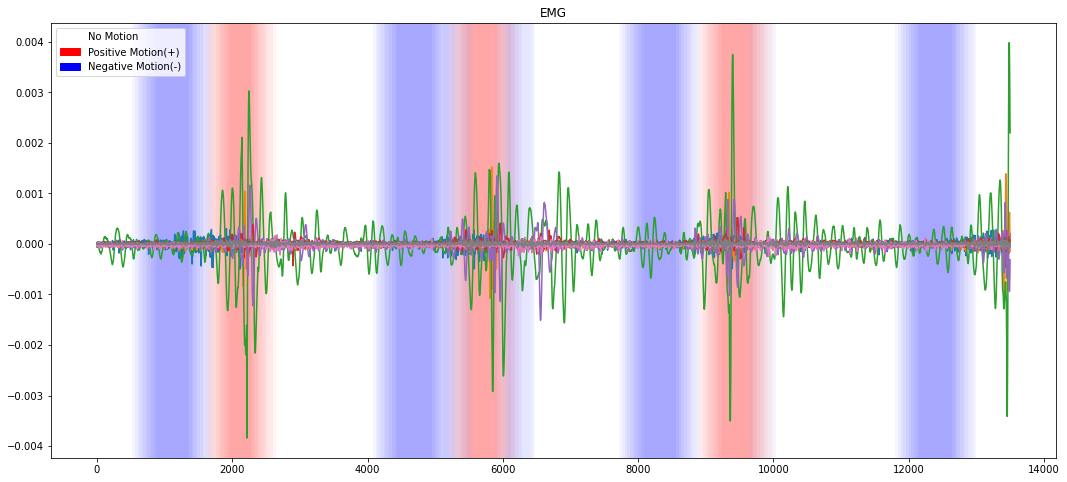

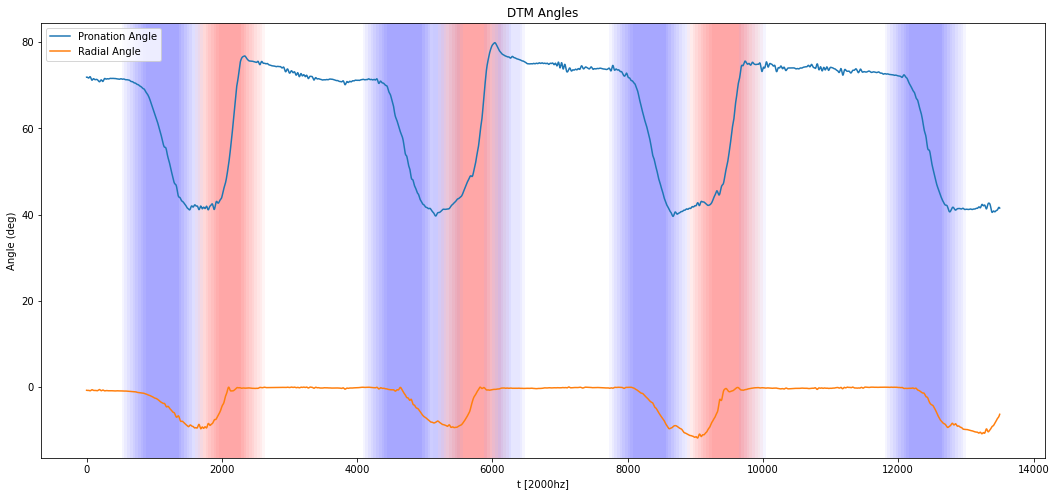

0 -> 55.792682926829265 %
1 -> 16.158536585365855 %
2 -> 28.048780487804876 %


(328, 400, 8)

In [4]:
X, y = prep_data_DTM(df,400,interval=40,Normalize=False,plot=True,angle_thresh=0.008,rms=False)
X.shape

## File Name Generation

In [5]:
files = []

In [6]:
path = 'Subjects/Fazil/day_04_24_21'
# trial_names = ['Hammer'] # 'Bulb','Hammer' ,'Cup','Screw'
trial_names = ['Bulb','Hammer' ,'Cup','Screw']
for exp in trial_names:
    for i in range(3):
        if(i==0):
            files.append(path+'/computed_'+exp+'.csv')
        else:
            files.append(path+'/computed_'+exp+'0'+str(i)+'.csv')
files

['Subjects/Fazil/day_04_24_21/computed_Bulb.csv',
 'Subjects/Fazil/day_04_24_21/computed_Bulb01.csv',
 'Subjects/Fazil/day_04_24_21/computed_Bulb02.csv',
 'Subjects/Fazil/day_04_24_21/computed_Hammer.csv',
 'Subjects/Fazil/day_04_24_21/computed_Hammer01.csv',
 'Subjects/Fazil/day_04_24_21/computed_Hammer02.csv',
 'Subjects/Fazil/day_04_24_21/computed_Cup.csv',
 'Subjects/Fazil/day_04_24_21/computed_Cup01.csv',
 'Subjects/Fazil/day_04_24_21/computed_Cup02.csv',
 'Subjects/Fazil/day_04_24_21/computed_Screw.csv',
 'Subjects/Fazil/day_04_24_21/computed_Screw01.csv',
 'Subjects/Fazil/day_04_24_21/computed_Screw02.csv']

In [ ]:
path = 'Subjects/Fazil/day_04_14_21'
# trial_names = ['Hammer','Bulb'] # 'Bulb','Hammer' ,'Cup','Screw'
trial_names = ['Bulb','Hammer' ,'Cup']
for exp in trial_names:
    for i in range(3):
        if(i==0):
            files.append(path+'/computed_'+exp+'.csv')
        else:
            files.append(path+'/computed_'+exp+'0'+str(i)+'.csv')
files

In [7]:
files_df = []
for file in files:
    files_df.append(pd.read_csv(file,index_col=0))

## Data Augumentation

In [ ]:
emg_labels = ['EMG1','EMG2','EMG3','EMG4','EMG5','EMG6','EMG8','EMG7']

In [ ]:
files_df_aug = []

for df in tqdm(files_df):
    theta = choice(np.linspace(0,0.4,10))
    emg_array = np.array(add__Gausian_noise(df[emg_labels],theta))
    df[emg_labels] = emg_array
    files_df_aug.append(df)

In [ ]:
files_df = files_df+files_df_aug

## Data Prep Pipeline

### Parameters

In [8]:
window = 400
interval = 6
Normalize = False
rms = False
angle_thresh_DTM = 0.008

In [9]:
X_dtm, y_dtm = multiple_prep_data_DTM(files_df,
                                      window,
                                      interval,
                                      Normalize,
                                      rms,
                                      angle_thresh_DTM)
print(X_dtm.shape,y_dtm.shape)


(126207, 400, 8) (126207, 3)


## Whole Normalize

In [10]:
X = X_dtm.reshape((X_dtm.shape[0]*X_dtm.shape[1],X_dtm.shape[2]))
X = min_max(X)
X_dtm = X.reshape(X_dtm.shape)

In [ ]:
np.save('prepared_data/X_dtm',X_dtm)
np.save('prepared_data/y_dtm',y_dtm)

In [ ]:
X_dtm = np.load('prepared_data/X_dtm.npy')
y_dtm = np.load('prepared_data/y_dtm.npy')

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_dtm, y_dtm,test_size=0.2)
for data in [X_train, X_test, y_train, y_test]:
    print(data.shape)

(100965, 400, 8)
(25242, 400, 8)
(100965, 3)
(25242, 3)


In [12]:
y_true = []
for d in y_test:
    idx = list(d).index(1)
    y_true.append(idx)

In [13]:
def count(y):
    s0 = 0
    s1 = 0
    s2 = 0
    for arr in y:
        if arr[0]==1:
            s0 = s0+1
        if arr[1]==1:
            s1 = s1+1
        if arr[2]==1:
            s2 = s2+1
    ls = [s0,s1,s2]
    for i in range(3):
        print(i,'-',ls[i],'[',ls[i]*100/len(y),'%]')

In [14]:
print(count(y_train))
print(count(y_test))

0 - 51119 [ 50.63041648095875 %]
1 - 13644 [ 13.51359381964047 %]
2 - 36202 [ 35.85598969940078 %]
None
0 - 12819 [ 50.78440694081293 %]
1 - 3318 [ 13.144758735440933 %]
2 - 9105 [ 36.07083432374614 %]
None


# InceptionTime Trainer

In [15]:
import numpy as np
import sklearn
import pandas as pd
import sys
import subprocess
import tensorflow as tf
from InceptionTime.classifiers.inception import Classifier_INCEPTION

## Build Model

In [16]:
clf = Classifier_INCEPTION('', (X_train.shape[1],X_train.shape[2]),nb_classes=3,
                            verbose=True,batch_size=300,nb_epochs=25,nb_filters=12,
                            depth=16, kernel_size=11)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 8)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 400, 32)      256         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 400, 8)       0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 400, 12)      3840        conv1d[0][0]                     
______________________________________________________________________________________________

In [ ]:
df_metrics = clf.fit(X_train, y_train, X_test, y_test, y_true,plot_test_acc=True)

Epoch 1/25
337/337 [==============================] - 93s 276ms/step - loss: 0.6277 - accuracy: 0.7324 - val_loss: 1.2343 - val_accuracy: 0.5202 - lr: 0.0010
Epoch 2/25
337/337 [==============================] - 93s 276ms/step - loss: 0.3521 - accuracy: 0.8667 - val_loss: 0.8085 - val_accuracy: 0.6761 - lr: 0.0010
Epoch 3/25
337/337 [==============================] - 97s 287ms/step - loss: 0.2846 - accuracy: 0.8922 - val_loss: 1.6241 - val_accuracy: 0.6491 - lr: 0.0010
Epoch 4/25
337/337 [==============================] - 102s 303ms/step - loss: 0.2518 - accuracy: 0.9049 - val_loss: 0.6535 - val_accuracy: 0.7813 - lr: 0.0010
Epoch 5/25
337/337 [==============================] - 101s 299ms/step - loss: 0.2337 - accuracy: 0.9110 - val_loss: 0.6255 - val_accuracy: 0.7590 - lr: 0.0010
Epoch 6/25
248/337 [=====================>........] - ETA: 24s - loss: 0.2204 - accuracy: 0.9164

In [ ]:
clf.model = load_model('last_model.hdf5')

In [ ]:
best_model = load_model('best_model.hdf5')
best_model.save('models/DTM_{}.hdf5'.format(window))

## Testing

In [ ]:
model = load_model('models/DTM_{}.hdf5'.format(window))

In [ ]:
mx_scaler = load(open('min_max.pkl', 'rb'))
X = X_dtm.reshape(X_dtm.shape[0]*X_dtm.shape[1],X_dtm.shape[2])
X = mx_scaler.transform(X)
X_dtm = X.reshape(X_dtm.shape)

In [ ]:
model.evaluate(X_dtm, y_dtm)

## Plot Results

In [ ]:
%matplotlib inline
metrics_df = pd.read_csv('df_metrics.csv')
best_model_df = pd.read_csv('df_best_model.csv')
history_df = pd.read_csv('history.csv')

In [ ]:
metrics_df

In [ ]:
history_df[['accuracy','val_accuracy']].plot(figsize=(14,8),title='Accuracy',grid=True,fontsize=15)
history_df[['loss','val_loss']].plot(figsize=(14,8),title='Loss',grid=True,fontsize=15)